In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import beta
import seaborn as sns
sns.set_context('paper', font_scale=1.5)
sns.set_style('ticks')
import pandas as pd

from pyplr import stlab
from pyplr.calibrate import CalibrationContext

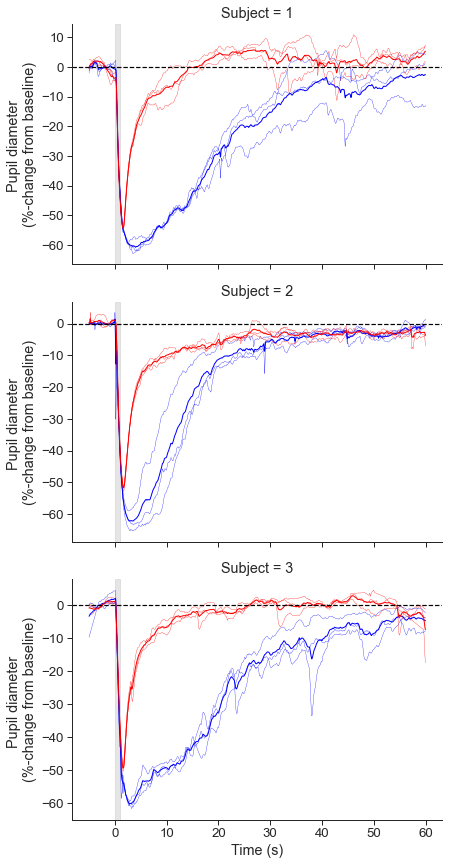

In [2]:
pipr = pd.read_csv('processed_PIPR.csv')
pipr.onset = (pipr.onset-600) * (1/120)
g = sns.FacetGrid(data=pipr, row='Subject', sharey=False,  margin_titles=False, height=4, aspect=1.5)
g.map_dataframe(sns.lineplot, x='onset', y='diameter_pc', estimator=None, units='event', lw=.3, hue='color', palette={'red':'r','blue':'b'})
avs = pipr.groupby(['Subject', 'color']).mean()
g.map_dataframe(sns.lineplot, x='onset', y='diameter_pc', ci=None, lw=1, hue='color', palette={'red':'r','blue':'b'})
for ax in g.axes:
    ax[0].axvspan(0, 1, color='k', alpha=.1)
    ax[0].axhline(0, 0, 1, color='k', ls='--')
    ax[0].set_xlabel('Time (s)')
    ax[0].set_ylabel('Pupil diameter \n(%-change from baseline)')
g.savefig('PIPRs.tiff', dpi=600)

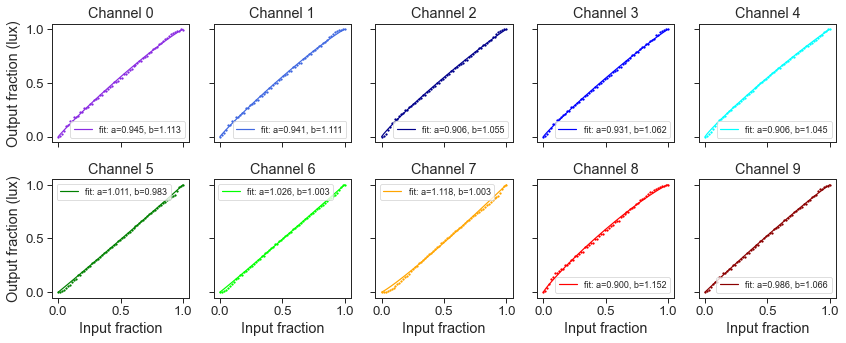

In [3]:
sns.set_context('paper', font_scale=1.5)
# load the sample spectra and convert to melanopic irradiance
cc = CalibrationContext('../data/S2_corrected_oo_spectra.csv', binwidth=1)

colors = stlab.get_led_colors()

fig, axs = plt.subplots(2,5, figsize=(12,5), sharex=True, sharey=True)
axs = [item for sublist in axs for item in sublist]

ir = cc.irradiance.loc[:, range(0,4096,65), :]

for idx, df in ir.groupby(level=0):
    xdata = df.index.get_level_values(1).to_numpy() / 4095
    ydata = df.values
    ydata = ydata / np.max(ydata)
    
    # Defines function we want to fit
    def func(x, a, b):
        return beta.cdf(x, a, b)

    axs[idx].scatter(xdata, ydata, color=colors[idx], s=2)
    
    # Fit
    popt, pcov = curve_fit(beta.cdf, xdata, ydata, p0=[2.0, 1.0])
    ypred = func(xdata, *popt)
    axs[idx].plot(xdata, ypred, color=colors[idx], label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
    axs[idx].set_title('Channel {}'.format(idx))
    axs[idx].legend()
    
for ax in [axs[0],axs[5]]:
    ax.set_ylabel('Output fraction (lux)')
for ax in axs[5:]:
    ax.set_xlabel('Input fraction')
#for ax in axs:
#    ax.set_aspect('equal', 'box')

for ax in axs:
    ax.legend(prop={'size': 9})
plt.tight_layout()
fig.savefig('../img/STLAB_luminance_linearity.svg')

In [4]:
cc.data.index.get_level_values(1).unique().to_numpy()

array([   0,   65,  130,  195,  260,  325,  390,  455,  520,  585,  650,
        715,  780,  845,  910,  975, 1040, 1105, 1170, 1235, 1300, 1365,
       1430, 1495, 1560, 1625, 1690, 1755, 1820, 1885, 1950, 2015, 2080,
       2145, 2210, 2275, 2340, 2405, 2470, 2535, 2600, 2665, 2730, 2795,
       2860, 2925, 2990, 3055, 3120, 3185, 3250, 3315, 3380, 3445, 3510,
       3575, 3640, 3705, 3770, 3835, 3900, 3965, 4030, 4095])

- do curve fitting and linearization in radiance rather than lux
- match top radiance for chirp in different wavelengths
- multiply by parametric output of beta function
- inverse function

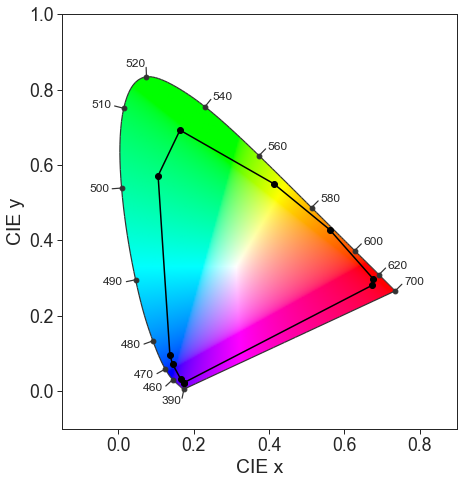

In [8]:
from colour.plotting import plot_chromaticity_diagram_CIE1931

from pyplr.CIE import get_CIE_CMF
from pyplr.spectools import spec_to_xyz

sns.set_context('paper', font_scale=2)


cmf = get_CIE_CMF(asdf=True, binwidth=1)

xyz = cc.data.loc[:, 4095, :].apply(lambda row: spec_to_xyz(row.to_numpy(), cmf), axis=1)
xyz = xyz.append(xyz.loc[0]).reset_index()
xyz

# set up figure
f, ax = plt.subplots(1, 1, figsize=(7,7))

# plotting the *CIE xy* chromaticity coordinates.
plot_chromaticity_diagram_CIE1931(standalone=False, axes=ax, title=False, show_spectral_locus=True)
ax.set_xlim((-.15,.9))
ax.set_ylim((-.1,1))
ax.plot(xyz['X'], xyz['Y'], color='k', lw=1.5, marker='o', markersize=6)
for item in ax.texts:
    item.set_fontsize(12)
f.savefig('../img/CIE_gamut.tiff', dpi=300, bbox_inches='tight')

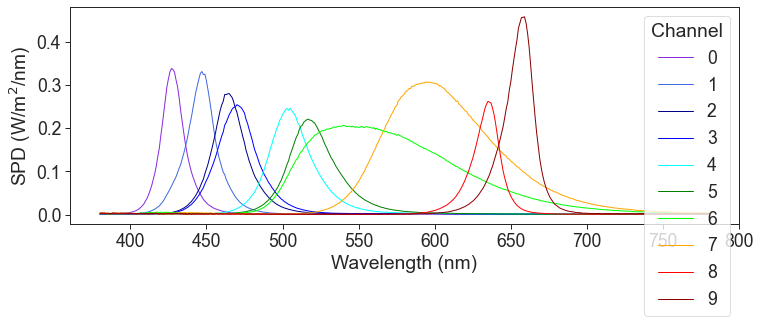

In [9]:
f, ax = plt.subplots(1, 1, figsize=(12,4))
d = cc.lkp.loc[:,4095, :]
for led, df in d.iterrows():
    color = colors[led]
    df.plot(c=color, lw=1, label=led)
ax.legend(title='Channel')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('SPD (W/m$^2$/nm)')
f.savefig('../img/STLAB_SPDs.svg', bbox_inches='tight')

In [ ]:
sns.set_context('poster')

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(12,4))
d = cc.lkp.loc[:,4095, :]

for led, df in d.iterrows():
    color = colors[led]
    df.plot(c=color, lw=3, label=led)
#ax.legend(title='Channel')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('SPD (W/m$^2$/nm)')
f.savefig('../img/STLAB_SPDs_poster.tiff', dpi=300, bbox_inches='tight')

In [ ]:
import os
import os.path as op
import glob

import numpy as np
import pandas as pd
import seaborn as sns

datadir = '../data/pupil_core_camera_sync_tests'
recordings = glob.glob(datadir + '/**/**/**/annotations.csv')

data = pd.DataFrame()
for rec in recordings:
    # Load annotations and get camera timestamps for detected light flash
    df = pd.read_csv(rec)
    eye_0 = df.loc[df.label=='light_on_eye_0', 'timestamp'].to_numpy()
    eye_1 = df.loc[df.label=='light_on_eye_1', 'timestamp'].to_numpy() 
    world = df.loc[df.label=='light_on_world', 'timestamp'].to_numpy()
    
    # Calculate timestamp differences and make DataFrame
    diffs = (pd.DataFrame(data=[(eye_0-world)*1000,
                                (eye_1-world)*1000,
                                (eye_0-eye_1)*1000],
                          index=['eye0 - world',
                                 'eye1 - world',
                                 'eye0 - eye1'])
               .T.melt(var_name='Comparison', 
                       value_name='Timestamp difference (ms)'))
    
    # Add categories for operating system and frames per second
    diffs['OS'] = 'macOS' if 'mac' in rec else 'Windows'
    diffs['FPS'] = '120' if '120_fps' in rec else '60'
    diffs.to_csv(op.join(op.dirname(rec), 'annotation_timestamp_diffs.csv'))
    
    # Append to master frame
    data = data.append(diffs)
data

In [ ]:
sns.set_context('paper', font_scale=2)
g = sns.catplot(data=data, 
                x='Comparison', 
                y='Timestamp difference (ms)', 
                row='OS', 
                col='FPS',
                kind='box', 
                order=['eye0 - world', 'eye1 - world', 'eye0 - eye1'],
                flierprops={'markersize':3})
g.savefig('./Pupil_Core_camera_sync.tiff', dpi=600)